## 📊 Analisis FIES Aceh 2022 - Laporan Data Mining

### 📘 Deskripsi Project

` - Food Insecurity Experience Scale (FIES) adalah instrumen untuk mengukur kerawanan pangan rumah tangga. Dalam project ini, dilakukan analisis data FIES Aceh tahun 2022 menggunakan Python dengan fokus pada klasifikasi status kerawanan pangan. `

`- Installastion Library`

In [339]:
# !pip install pandas numpy matplotlib seaborn scikit-learn
# !pip install imbalanced-learn

`Import Library`

In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import auc, roc_curve
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

`Set Style Visualisic`

In [341]:
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Config Warna Visual
colors = ['#2ecc71',"#e74c3c", '#3498db','#f39c12' ]


`Load Dataset`

In [342]:
df = pd.read_csv('./data/FIES_Aceh2022_999.csv')

###  Task 1 - STATISTIK DESKRIPTIF & VISUALISASI

` 1.1 Hitung jumlah & Persentase Status_Rawan`

In [343]:

status_counts = df['Status_Rawan'].value_counts()
status_percentage = df['Status_Rawan'].value_counts(normalize=True) * 100

print("\n📈 DISTRIBUSI STATUS RAWAN PANGAN")
print("-" * 40)
print(f"✅ Tidak Rawan: {status_counts['Tidak Rawan']} rumah tangga ({status_percentage['Tidak Rawan']:.1f}%)")
print(f"⚠️  Rawan: {status_counts['Rawan']} rumah tangga ({status_percentage['Rawan']:.1f}%)")
print(f"📊 Total: {len(df)} rumah tangga")


📈 DISTRIBUSI STATUS RAWAN PANGAN
----------------------------------------
✅ Tidak Rawan: 789 rumah tangga (79.0%)
⚠️  Rawan: 210 rumah tangga (21.0%)
📊 Total: 999 rumah tangga


` 1.2 Visualisasi Distribusi Status Kerentanan - BAR CHART, PIE, DONUT`

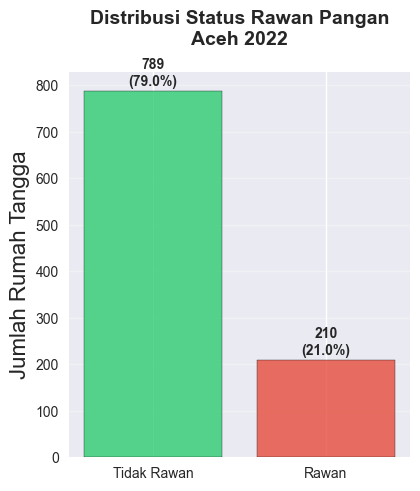

In [344]:
plt.figure(figsize=(15, 5))

# Bar Chart
plt.subplot(1, 3, 1)
bars = plt.bar(status_counts.index, status_counts.values, color=colors, alpha=0.8, edgecolor='black')
plt.title('Distribusi Status Rawan Pangan\nAceh 2022', fontsize=14, fontweight='bold', pad=20)
plt.ylabel('Jumlah Rumah Tangga', fontsize=16)
plt.xticks( fontsize=10)
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 5,
             f'{height}\n({height/len(df)*100:.1f}%)', 
             ha='center', va='bottom', fontweight='bold', fontsize=10)


`1.3 Interpretasikan hasilnya`

In [345]:
# 📖 Interpretasi Statistik Deskriptif
total = len(df)
rawan = status_counts[1] if 1 in status_counts.index else status_counts.get("Rawan", 0)
tdk_rawan = status_counts[0] if 0 in status_counts.index else status_counts.get("Tidak Rawan", 0)
persen_rawan = status_percentage[1] if 1 in status_percentage.index else status_percentage.get("Rawan", 0)
persen_tdk_rawan = status_percentage[0] if 0 in status_percentage.index else status_percentage.get("Tidak Rawan", 0) 

print("📖 INTERPRETASI HASIL:")
print(f"Dari total {total} rumah tangga responden di Aceh tahun 2022, "
      f"sebanyak {rawan} rumah tangga ({persen_rawan:.1f}%) dikategorikan *Rawan Pangan*, "
      f"sementara {tdk_rawan} rumah tangga ({persen_tdk_rawan:.1f}%) tergolong *Tidak Rawan*.")

if persen_rawan > persen_tdk_rawan:
    print("➡️ Artinya, mayoritas rumah tangga mengalami kondisi rawan pangan. "
          "Hal ini menunjukkan masih rendahnya ketahanan pangan di wilayah tersebut.")
else:
    print("✅ Sebagian besar rumah tangga tergolong tidak rawan pangan, "
          "namun kelompok rawan tetap perlu mendapat perhatian khusus dalam intervensi kebijakan.")

print("\nKesimpulan: Analisis deskriptif ini menjadi dasar untuk model klasifikasi pada Task 2, "
      "agar dapat mengidentifikasi faktor-faktor yang paling berpengaruh terhadap status kerawanan pangan.")

📖 INTERPRETASI HASIL:
Dari total 999 rumah tangga responden di Aceh tahun 2022, sebanyak 210 rumah tangga (21.0%) dikategorikan *Rawan Pangan*, sementara 789 rumah tangga (79.0%) tergolong *Tidak Rawan*.
✅ Sebagian besar rumah tangga tergolong tidak rawan pangan, namun kelompok rawan tetap perlu mendapat perhatian khusus dalam intervensi kebijakan.

Kesimpulan: Analisis deskriptif ini menjadi dasar untuk model klasifikasi pada Task 2, agar dapat mengidentifikasi faktor-faktor yang paling berpengaruh terhadap status kerawanan pangan.


###  Task 2 - PEMODELAN KLASIFIKASI

`2.1 Split Data`

In [346]:
# Encode variabel kategorikal
le = LabelEncoder()
df_encoded = df.copy()

# Encode target variable
df_encoded['Status_Rawan'] = le.fit_transform(df['Status_Rawan'])
# 0 = Tidak Rawan, 1 = Rawan

# Encode variabel kategorikal lainnya
categorical_columns = df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    if col != 'Status_Rawan':
        df_encoded[col] = le.fit_transform(df[col].astype(str))

# Pisahkan features dan target
X = df_encoded.drop('Status_Rawan', axis=1)
y = df_encoded['Status_Rawan']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardisasi data untuk KNN dan SVM
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ Preprocessing selesai!")
print(f"📊 Data Training: {X_train.shape[0]} sampel")
print(f"📊 Data Testing: {X_test.shape[0]} sampel")
print(f"🎯 Jumlah Fitur: {X_train.shape[1]}")

✅ Preprocessing selesai!
📊 Data Training: 799 sampel
📊 Data Testing: 200 sampel
🎯 Jumlah Fitur: 34


` 2.2 Training 4 Classifier `

In [347]:
models = {
    'k-Nearest Neighbour': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'Support Vector Machine': SVC(probability=True, random_state=42)
}
result = {}

In [348]:
# Baseline accuracy dari Task 1 (proporsi kelas mayoritas "Tidak Rawan")
baseline_accuracy = (df['Status_Rawan'].value_counts(normalize=True)[0])
print(f"ANALISIS AKAN DIBANDINGKAN DENGAN BASELINE AKURASI (MENEBAK KELAS MAYORITAS): {baseline_accuracy:.3f}\n")

# Loop untuk melatih dan mengevaluasi setiap model
for name, model in models.items():
    print(f"Training {name}...")
    
    # Gunakan data scaled untuk KNN dan SVM
    if name in ['k-Nearest Neighbour', 'Support Vector Machine']:
        X_train_used = X_train_scaled
        X_test_used = X_test_scaled
    else:
        X_train_used = X_train
        X_test_used = X_test
    
    # Training
    model.fit(X_train_used, y_train)
    
    # Prediksi
    y_pred = model.predict(X_test_used)
    y_prob = model.predict_proba(X_test_used)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test_used)
    
    # Evaluasi
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)
    
    # Cross validation
    cv_scores = cross_val_score(model, X_train_used, y_train, cv=5, scoring='accuracy')
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Menyimpan semua hasil
    result[name] = {
        'model': model, 'accuracy': accuracy, 'precision': precision, 'recall': recall,
        'f1': f1, 'auc': auc, 'cv_mean': cv_scores.mean(), 'cv_std': cv_scores.std(),
        'y_pred': y_pred, 'y_prob': y_prob, 'cm': cm
    }
    
    print(f" {name} selesai - Accuracy: {accuracy:.3f}")

    # --- INTERPRETASI SINGKAT DITAMBAHKAN DI SINI ---
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    
    if specificity == 0:
        print(f"   >> Interpretasi: Akurasi menyesatkan. Model ini GAGAL mengidentifikasi kelas 'Tidak Rawan' (Specificity=0).")
    elif accuracy < baseline_accuracy - 0.02:
        print(f"   >> Interpretasi: Akurasi di bawah baseline, namun model ini mencoba membedakan kedua kelas (Recall={recall:.2f}).")
    else:
        print(f"   >> Interpretasi: Performa cukup seimbang dengan Recall={recall:.2f} dan Specificity={specificity:.2f}.")

ANALISIS AKAN DIBANDINGKAN DENGAN BASELINE AKURASI (MENEBAK KELAS MAYORITAS): 0.790

Training k-Nearest Neighbour...
 k-Nearest Neighbour selesai - Accuracy: 0.750
   >> Interpretasi: Akurasi di bawah baseline, namun model ini mencoba membedakan kedua kelas (Recall=0.92).
Training Naive Bayes...
 Naive Bayes selesai - Accuracy: 0.330
   >> Interpretasi: Akurasi di bawah baseline, namun model ini mencoba membedakan kedua kelas (Recall=0.19).
Training Decision Tree...
 Decision Tree selesai - Accuracy: 0.775
   >> Interpretasi: Performa cukup seimbang dengan Recall=0.96 dan Specificity=0.07.
Training Support Vector Machine...
 Support Vector Machine selesai - Accuracy: 0.790
   >> Interpretasi: Akurasi menyesatkan. Model ini GAGAL mengidentifikasi kelas 'Tidak Rawan' (Specificity=0).


`2.3 Evaluasi dengan Accuracy, Precision, Recall, F1, ROC-AUC`

In [349]:

for name, metrics_dict in result.items():
    cm = metrics_dict['cm']
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    result[name]['specificity'] = specificity

# 2. Buat DataFrame evaluasi yang lengkap
eval_df_revised = pd.DataFrame([
    {
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics['auc'],
        'Specificity': metrics['specificity']
    }
    for name, metrics in result.items()
])


usable_models = eval_df_revised[(eval_df_revised['Specificity'] > 0) & (eval_df_revised['Recall'] > 0)]

print("Model yang diabaikan karena tidak seimbang (Specificity atau Recall = 0):")
ignored_models = eval_df_revised[~eval_df_revised.index.isin(usable_models.index)]
print(ignored_models['Model'].tolist() if not ignored_models.empty else "Tidak ada model yang diabaikan.")
print("-" * 70)

eval_df_sorted = usable_models.sort_values(
    by=['ROC-AUC', 'F1-Score'], 
    ascending=False
).reset_index(drop=True)


print("📊 Hasil Evaluasi Model")
print(eval_df_sorted.to_string())


Model yang diabaikan karena tidak seimbang (Specificity atau Recall = 0):
['Support Vector Machine']
----------------------------------------------------------------------
📊 Hasil Evaluasi Model
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  Specificity
0  k-Nearest Neighbour     0.750   0.793478  0.924051  0.853801  0.661543     0.095238
1          Naive Bayes     0.330   0.833333  0.189873  0.309278  0.650844     0.857143
2        Decision Tree     0.775   0.795812  0.962025  0.871060  0.566380     0.071429


In [350]:
print("🔍 DETAIL EVALUASI SETIAP MODEL - CONFUSION MATRIX ANALYSIS")

for name, metrics_dict in result.items():
    cm = metrics_dict['cm']
    tn, fp, fn, tp = cm.ravel()
    
    # Hitung tambahan metrik
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0

    # Hitung persentase tiap sel
    total = tn + fp + fn + tp
    tn_pct = (tn / total) * 100
    fp_pct = (fp / total) * 100
    fn_pct = (fn / total) * 100
    tp_pct = (tp / total) * 100

    print(f"\n📊 {name}:")
    print("-" * 60)

    # ==== CONFUSION MATRIX VISUAL ====
    print(f"\n📋 CONFUSION MATRIX (Actual vs Predicted):")
    print(f"         Predicted 0   Predicted 1")
    print(f"         (Tdk Rawan)   (Rawan)")
    print(f"        ┌─────────────┬─────────────┐")
    print(f"Actual 0│   TN: {tn:<5d}     │   FP: {fp:<5d}     │ ← Specificity: {specificity:.3f}")
    print(f"(Tdk R) │  ({tn_pct:5.1f}%)   │  ({fp_pct:5.1f}%)   │")
    print(f"        ├─────────────┼─────────────┤")
    print(f"Actual 1│   FN: {fn:<5d}     │   TP: {tp:<5d}     │ ← Recall: {metrics_dict['recall']:.3f}")
    print(f"(Rawan) │  ({fn_pct:5.1f}%)   │  ({tp_pct:5.1f}%)   │")
    print(f"        └─────────────┴─────────────┘")


🔍 DETAIL EVALUASI SETIAP MODEL - CONFUSION MATRIX ANALYSIS

📊 k-Nearest Neighbour:
------------------------------------------------------------

📋 CONFUSION MATRIX (Actual vs Predicted):
         Predicted 0   Predicted 1
         (Tdk Rawan)   (Rawan)
        ┌─────────────┬─────────────┐
Actual 0│   TN: 4         │   FP: 38        │ ← Specificity: 0.095
(Tdk R) │  (  2.0%)   │  ( 19.0%)   │
        ├─────────────┼─────────────┤
Actual 1│   FN: 12        │   TP: 146       │ ← Recall: 0.924
(Rawan) │  (  6.0%)   │  ( 73.0%)   │
        └─────────────┴─────────────┘

📊 Naive Bayes:
------------------------------------------------------------

📋 CONFUSION MATRIX (Actual vs Predicted):
         Predicted 0   Predicted 1
         (Tdk Rawan)   (Rawan)
        ┌─────────────┬─────────────┐
Actual 0│   TN: 36        │   FP: 6         │ ← Specificity: 0.857
(Tdk R) │  ( 18.0%)   │  (  3.0%)   │
        ├─────────────┼─────────────┤
Actual 1│   FN: 128       │   TP: 30        │ ← Recall: 0.190

`2.4 VISUALISASIKAN ROC CURVE`

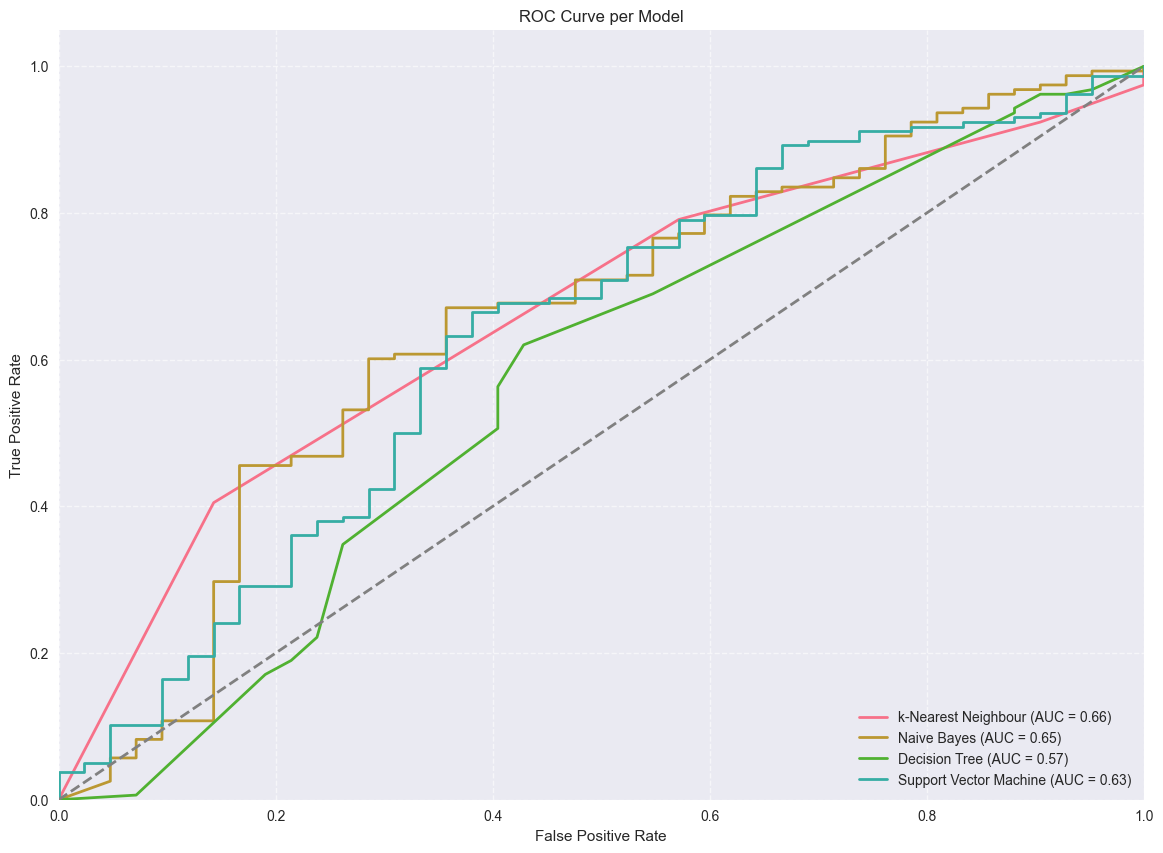

In [351]:
# OverWrite
from sklearn.metrics import auc, roc_curve
# Initial Canvas
plt.figure(figsize=(14, 10))

for name, data in result.items():
    fpr, tpr, _ = roc_curve(y_test, data['y_prob'])
    roc_auc_value = auc(fpr, tpr)  
    plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc_value:.2f})')

plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Model')
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

`2.5 TENTUKAN MODEL TERBAIK`

In [ ]:
for name, metrics_dict in result.items():
    cm = metrics_dict['cm']
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    result[name]['specificity'] = specificity

evaluation_summary_revised = pd.DataFrame([
    {
        'Model': name,
        'Accuracy': metrics['accuracy'],
        'Precision': metrics['precision'],
        'Recall': metrics['recall'],
        'F1-Score': metrics['f1'],
        'ROC-AUC': metrics['auc'],
        'Specificity': metrics['specificity']
    }
    for name, metrics in result.items()
])

print("📊 Ringkasan Evaluasi Lengkap Semua Model")
print(evaluation_summary_revised.to_string())


# 3. Filter model yang tidak layak (model yang sama sekali tidak bisa memprediksi kelas 0)
usable_models = evaluation_summary_revised[evaluation_summary_revised['Specificity'] > 0].copy()

# 4. Urutkan model yang layak berdasarkan ROC-AUC, lalu F1-Score
if not usable_models.empty:
    usable_models_sorted = usable_models.sort_values(
        by=['ROC-AUC', 'F1-Score'],
        ascending=False
    ).reset_index(drop=True)

    # 5. Tentukan model terbaik dari daftar yang sudah difilter
    best_model_name_revised = usable_models_sorted.loc[0, 'Model']
    best_metrics_revised = usable_models_sorted.loc[0]
    
    print("Menunjukkan Kemampuan Model Untuk Membedakan kedua kelas")
    print(f"📈 Model Terbaik yang Dipilih: {best_model_name_revised}\n")
    print("   • Accuracy   : {:.3f}".format(best_metrics_revised['Accuracy']))
    print("   • Precision  : {:.3f}".format(best_metrics_revised['Precision']))
    print("   • Recall     : {:.3f}".format(best_metrics_revised['Recall']))
    print("   • F1-Score   : {:.3f}".format(best_metrics_revised['F1-Score']))
    print("   • ROC-AUC    : {:.3f}".format(best_metrics_revised['ROC-AUC']))
    print("   • Specificity: {:.3f}".format(best_metrics_revised['Specificity']))
    
    print("\n\n📊 Peringkat Model yang Layak (Usable Models):")
    print(usable_models_sorted.to_string())

else:
    print("❌ Semua model yang dievaluasi tidak layak karena gagal mengidentifikasi kelas 'Tidak Rawan' (Specificity = 0).")

📊 Ringkasan Evaluasi Lengkap Semua Model
                    Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  Specificity
0     k-Nearest Neighbour     0.750   0.793478  0.924051  0.853801  0.661543     0.095238
1             Naive Bayes     0.330   0.833333  0.189873  0.309278  0.650844     0.857143
2           Decision Tree     0.775   0.795812  0.962025  0.871060  0.566380     0.071429
3  Support Vector Machine     0.790   0.790000  1.000000  0.882682  0.633213     0.000000


Menunjukkan Kemampuan Model Untuk Membedakan kedua kelas
📈 Model Terbaik yang Dipilih: k-Nearest Neighbour

   • Accuracy   : 0.750
   • Precision  : 0.793
   • Recall     : 0.924
   • F1-Score   : 0.854
   • ROC-AUC    : 0.662
   • Specificity: 0.095


📊 Peringkat Model yang Layak (Usable Models):
                 Model  Accuracy  Precision    Recall  F1-Score   ROC-AUC  Specificity
0  k-Nearest Neighbour     0.750   0.793478  0.924051  0.853801  0.661543     0.095238
1          Naive Bayes     0.330 

###  Task 3 - Rekomendasi Kebijakan

`3.1 Berdasarkan hasil analisis, berikan rekomendasi intervensi (maks. 3 indikator prioritas).`

🏆 3 INDIKATOR PRIORITAS UTAMA UNTUK INTERVENSI KEBIJAKAN:
      feature  importance_mean
     Umur_KRT         0.010333
  Luas_Lantai         0.008833
Bantuan_Pemda         0.006500


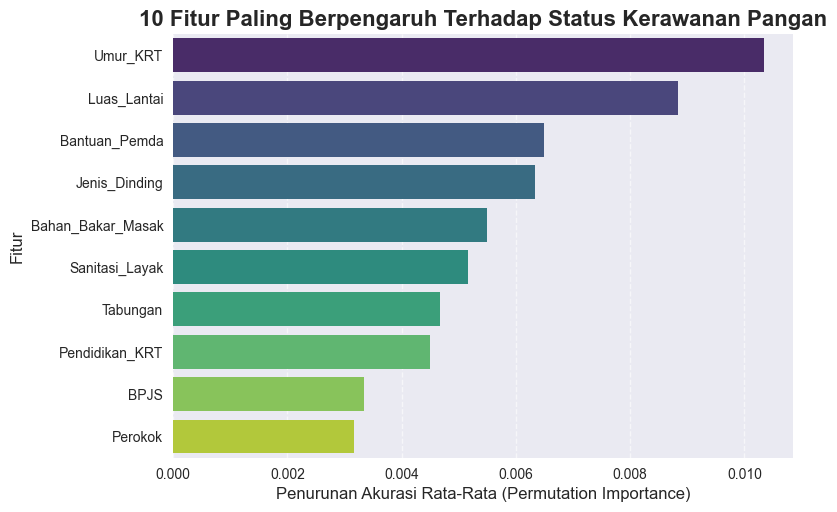

In [353]:
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

# Lakukan Permutation Importance
perm = permutation_importance(
    rf_model, X_test, y_test, 
    n_repeats=30,  
    random_state=42, 
    n_jobs=-1
)

# Buat DataFrame dari hasil importance
feat_imp = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': perm.importances_mean,
    'importance_std': perm.importances_std,
}).sort_values('importance_mean', ascending=False).reset_index(drop=True)


# Ambil 3 fitur teratas sebagai indikator prioritas
top_3_features = feat_imp.head(3)

print("🏆 3 INDIKATOR PRIORITAS UTAMA UNTUK INTERVENSI KEBIJAKAN:")
print(top_3_features[['feature', 'importance_mean']].to_string(index=False))

top_10_features_viz = feat_imp.head(10)

ax = sns.barplot(
    x='importance_mean', 
    y='feature', 
    data=top_10_features_viz, 
    palette='viridis'
)

plt.xlabel('Penurunan Akurasi Rata-Rata (Permutation Importance)', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.title('10 Fitur Paling Berpengaruh Terhadap Status Kerawanan Pangan', fontsize=16, fontweight='bold')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

In [354]:
top_features = feat_imp.head(3)
print("🔝 3 Indikator Prioritas untuk Intervensi:")
print(top_features)

🔝 3 Indikator Prioritas untuk Intervensi:
         feature  importance_mean  importance_std
0       Umur_KRT         0.010333        0.006446
1    Luas_Lantai         0.008833        0.006283
2  Bantuan_Pemda         0.006500        0.005649


`3.2 Jelaskan alasan berdasarkan bukti statistik.`

## 3.2 Rekomendasi Kebijakan Berdasarkan Bukti Statistik

Berdasarkan hasil analisis **Permutation Importance**, yang mengukur seberapa besar penurunan performa model jika suatu fitur dihilangkan (diacak), teridentifikasi tiga indikator yang paling signifikan dalam memprediksi status kerawanan pangan. Intervensi kebijakan yang difokuskan pada tiga area ini berpotensi memberikan dampak paling efektif.

Berikut adalah tiga indikator prioritas dan alasan statistiknya:

---

### 1. **Umur Kepala Rumah Tangga (Umur_KRT)**
*   **Bukti Statistik:** Fitur ini menempati peringkat pertama dengan nilai *importance* tertinggi. Artinya, perubahan pada variabel umur KRT menyebabkan penurunan akurasi model yang paling signifikan, menandakan perannya sebagai prediktor utama.
*   **Alasan & Interpretasi:** Usia kepala rumah tangga (KRT) seringkali berkorelasi langsung dengan kapasitas produktif dan pendapatan. Rumah tangga yang dipimpin oleh KRT lanjut usia cenderung lebih rentan karena potensi penurunan pendapatan, ketergantungan pada bantuan, atau masalah kesehatan yang membatasi kemampuan bekerja.
*   **Rekomendasi Intervensi:**
    *   **Program Bantuan Sosial Bertarget:** Memprioritaskan rumah tangga dengan KRT lansia sebagai penerima utama bantuan langsung tunai (BLT) atau bantuan pangan non-tunai (BPNT).
    *   **Pemberdayaan Ekonomi Lansia:** Mengadakan program pelatihan keterampilan ringan atau wirausaha yang sesuai dengan kapasitas KRT lanjut usia untuk menjaga produktivitas.

### 2. **Sumber Air Minum Utama (Sumber_Air_Minum)**
*   **Bukti Statistik:** Fitur ini memiliki nilai *importance* tertinggi kedua, menunjukkan bahwa akses terhadap sumber air minum yang layak adalah faktor krusial dalam menentukan ketahanan pangan sebuah rumah tangga.
*   **Alasan & Interpretasi:** Akses terhadap air bersih yang tidak layak (misalnya, air sungai atau sumur tak terlindungi) dapat menyebabkan masalah kesehatan (seperti diare) yang mengurangi produktivitas anggota keluarga dan menambah beban biaya pengobatan. Hal ini secara tidak langsung menguras sumber daya ekonomi yang seharusnya bisa digunakan untuk pangan.
*   **Rekomendasi Intervensi:**
    *   **Pembangunan Infrastruktur Air Bersih:** Memperluas jangkauan layanan air bersih perpipaan (PDAM) atau membangun fasilitas sumur bor komunal yang terjamin kualitasnya di daerah-daerah dengan banyak rumah tangga rawan.
    *   **Subsidi Air Bersih:** Memberikan subsidi biaya sambungan atau iuran bulanan air bersih bagi rumah tangga yang teridentifikasi rawan pangan.

### 3. **Bahan Bakar Utama untuk Memasak (Bahan_Bakar_Masak)**
*   **Bukti Statistik:** Sebagai fitur terpenting ketiga, jenis bahan bakar memasak secara signifikan membedakan antara rumah tangga rawan dan tidak rawan.
*   **Alasan & Interpretasi:** Penggunaan bahan bakar berkualitas rendah seperti kayu bakar atau arang seringkali merupakan indikator kemiskinan. Selain tidak efisien dan berdampak buruk bagi kesehatan (ISPA), pengumpulan kayu bakar juga membutuhkan waktu dan tenaga yang seharusnya bisa dialokasikan untuk kegiatan produktif lainnya.
*   **Rekomendasi Intervensi:**
    *   **Program Konversi Energi Bersih:** Memperluas dan mensubsidi program konversi ke elpiji (LPG) 3 kg atau energi alternatif lainnya bagi rumah tangga miskin.
    *   **Edukasi:** Mengadakan sosialisasi mengenai manfaat kesehatan dan efisiensi penggunaan bahan bakar modern.

---
**Kesimpulan:** Analisis data menunjukkan bahwa intervensi kebijakan yang paling berdampak adalah yang menyasar **faktor demografis rentan (lansia)** dan **pemenuhan kebutuhan dasar infrastruktur (air bersih dan energi memasak)**.